In [255]:
import numpy as np

In [256]:
import os
import cv2

try:
    os.remove("dataset/README")
except:
    print("README not found")

README not found


In [257]:
# pip install natsort 
from natsort import natsorted

all_images = []
all_labels = []

entries = os.listdir("dataset")
# Natsort is used to sort the images in the order of their names which the normal sort fails to do
entries = natsorted(entries)
for i,entry in enumerate(entries):
    images = os.listdir("dataset/"+entry)
    images = natsorted(images)
    for image in images:
        # Reading the image and converting it to grayscale
        img = cv2.imread("dataset/"+entry+"/"+image,cv2.IMREAD_GRAYSCALE)
        # Flatten / normalize the image
        all_images.append(img.flatten()/255)
        all_labels.append(i+1)

# Generating Data matrix
all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_labels=all_labels.reshape(all_labels.shape[0],-1)

print(f"Images shape: {all_images.shape}")
print(f"Labels shape: {all_labels.shape}")

Images shape: (400, 10304)
Labels shape: (400, 1)


In [258]:
# Splitting the data into train and test (Odd images for training and even images for testing) <<-- This is a bad way to do it
Xtrain = all_images[1::2]
Ytrain = all_labels[1::2]
Xtest = all_images[0::2]
Ytest = all_labels[0::2]

print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtrain shape: (200, 10304)
Ytrain shape: (200, 1)
Xtest shape: (200, 10304)
Ytest shape: (200, 1)


In [259]:
Xtrain_transposed = Xtrain.transpose()
means = [np.mean(row) for row in Xtrain_transposed]
means = np.array(means)
print(f"Means shape: {means.shape}")

Means shape: (10304,)


In [260]:
Z = Xtrain - means
print(f"Z shape: {Z.shape}")
cov = 1/len(Xtrain) * np.matmul(Z.transpose(),Z)
print(f"Covariance shape: {cov.shape}")

Z shape: (200, 10304)


Covariance shape: (10304, 10304)


In [261]:
eig_values, eig_vectors = np.linalg.eigh(cov)
idx = eig_values.argsort()[::-1]  
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:,idx]

In [262]:
def get_dimensions(eigen_values, alpha):
    total = eig_values.sum()
    sum=0
    for i,val in enumerate(eigen_values):
        sum+=val
        if sum/total >= alpha:
            break
    return i+1

In [263]:
alphas = [0.8,0.85,0.9,0.95]
r = [get_dimensions(eig_values,alpha) for alpha in alphas]
r

[37, 53, 77, 116]

In [264]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , accuracy_score
from sklearn.model_selection import GridSearchCV
p_train = []
p_test = []

for dim in (r):
    
    p_train_data = np.matmul(eig_vectors[:, 0:dim].T, Xtrain.T).T
    p_test_data = np.matmul(eig_vectors[:, 0:dim].T, Xtest.T).T

    p_train.append(p_train_data)
    p_test.append(p_test_data)

In [265]:
from sklearn.metrics import make_scorer

knn = KNeighborsClassifier()
parameters = {"n_neighbors":list(range(1,10,2))}
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(knn,param_grid=parameters,cv=5,return_train_score=True,scoring=scorer)

In [266]:
preds = []
for i in range(len(p_train)):
    grid_search.fit(p_train[i],Ytrain.ravel())
    print(f"For alpha = {alphas[i]}, best parameters are {grid_search.best_params_} and best score is {grid_search.best_score_}")
    y_pred = grid_search.best_estimator_.predict(p_test[i])
    preds.append(y_pred)

For alpha = 0.8, best parameters are {'n_neighbors': 1} and best score is 0.8949999999999999
For alpha = 0.85, best parameters are {'n_neighbors': 1} and best score is 0.9049999999999999
For alpha = 0.9, best parameters are {'n_neighbors': 1} and best score is 0.9
For alpha = 0.95, best parameters are {'n_neighbors': 1} and best score is 0.9049999999999999


In [267]:
for i in range(len(preds)):
    print(f"Test Accuracy for alpha = {alphas[i]} is {accuracy_score(Ytest.ravel(),preds[i])}")

Test Accuracy for alpha = 0.8 is 0.93
Test Accuracy for alpha = 0.85 is 0.94
Test Accuracy for alpha = 0.9 is 0.945
Test Accuracy for alpha = 0.95 is 0.935


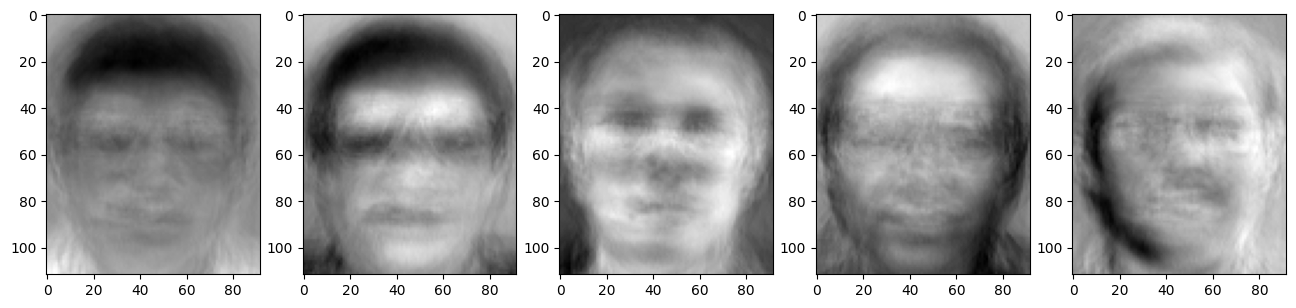

In [280]:
import matplotlib.pyplot as plt

def show_faces(imgs):
    plt.figure(figsize=(16,8))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(imgs[:,i].reshape(112,92),cmap='gray')
    plt.show()

show_faces(eig_vectors[:,:5])


In [274]:
eig_vectors.shape

(10304, 10304)